Vítejte u třetího projektu do SUI! V tomto projektu si procvičíte trénování jednoduchých neuronových sítí. Dost jednoduchých na to, abyste pro výpočty nepotřebovali grafickou kartu. Na druhé straně, dost složitých na to, abychom Vás již netrápili implementaci v holém NumPy. Vaším nultým úkolem bude nainstalovat si PyTorch, na [domovské stránce projektu](https://pytorch.org/) si můžete nechat vygenerovat instalační příkaz pro Vaše potřeby.

Odevzdejte prosím dvojici souborů: Vyrenderované PDF a vyexportovaný Python (File -> Download as). Obojí **pojmenujte loginem vedoucího týmu**. U PDF si pohlídejte, že Vám nemizí kód za okrajem stránky.

V jednotlivých buňkách s úkoly (což nejsou všechny) nahrazujte `pass` a `None` vlastním kódem.

V průběhu řešení se vždy vyvarujte cyklení po jednotlivých datech.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Celý tento projekt bude věnován regresi, tj. odhadu spojité výstupní veličiny.
V první části projektu budete pracovat s následující funkcí:

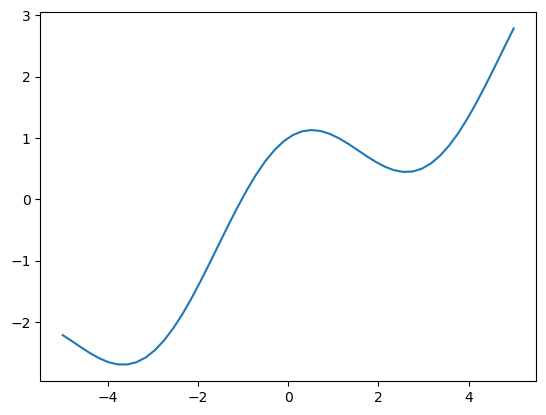

In [2]:
def func(x):
    return torch.cos(x) + x/2

xs = np.linspace(-5, 5, 50)

plt.plot(xs, func(torch.tensor(xs)))
plt.show()

Vaším prvním úkolem bude pomocí PyTorche vypočítat hodnoty derivace této funkce na rozsahu <-5, 5>.
Vytvořte si tensor `x`ů a řekněte PyTorchi, že budete vzhledem k němu chtít spočítat gradienty (defaultně se to u `Tensor`u nepředpokládá).
Pomocí back-propagace je pak vypočítejte.
PyTorch umí backpropagovat jenom skalár, najděte tedy způsob, jak agregovat všechny výstupy funkce tak, aby složky gradientu agregované hodnoty byly hodnotami derivace funkce `func` v jednotlivých `x`ech.

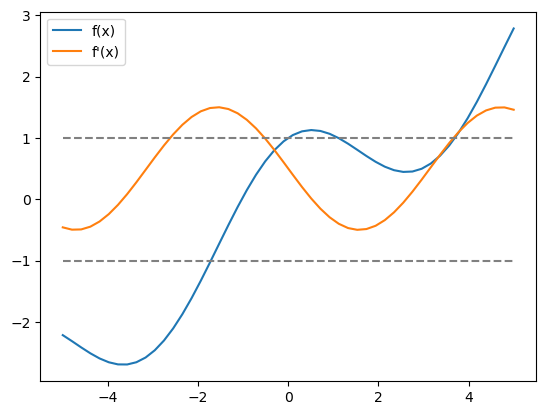

In [3]:
xs = torch.tensor(np.linspace(-5, 5, 50), requires_grad=True)
fs = func(xs)

for f in fs:
    f.backward(retain_graph=True)

plt.plot(xs.detach(), fs.detach(), label="f(x)")
plt.plot(xs.detach(), xs.grad, label="f'(x)")
plt.plot(xs.detach(),  1 * np.ones(xs.shape[0]), color='gray', linestyle='--')
plt.plot(xs.detach(), -1 * np.ones(xs.shape[0]), color='gray', linestyle='--')
plt.legend(loc="upper left")
plt.show()

Dále budete hledat lokální minimum této funkce.
Naimplementujte funkci `tangent_minimum`, která -- v blízké podobnosti metodě tečen -- nalezne řešení, resp. vrátí posloupnost jednotlivých bodů, jimiž při hledání minima prošla.
Jejími vstupy jsou: 
* `function` -- PyTorch-kompatibilní funkce
* `x0` -- počáteční bod
* `nb_steps` -- zadaný počet kroků, který má být proveden. Ve výstupu tedy bude `nb_steps + 1` položek (vč. `x0`)

Reálně implementujte gradient descent, tedy iterativně vypočítejte hodnotu gradientu (derivace) v aktuálním bodě řešení a odečtěte ji od onoho bodu.
Neuvažujte žádnou learning rate (resp. rovnou jedné) a nepoužívejte žádné vestavěné optimalizátory z PyTorche.

Zbylý kód v buňce pak funkci zavolá a vykreslí, jak postupovala.

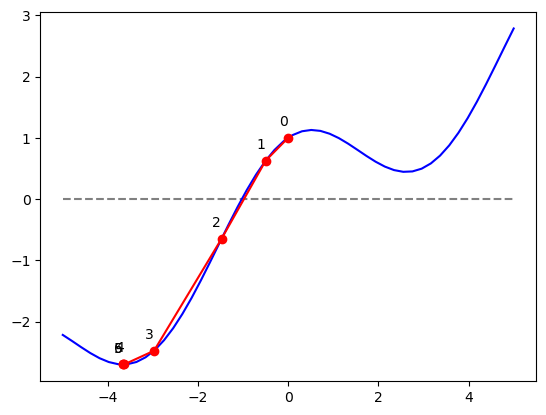

In [4]:
def tangent_minimum(function, x0, nb_steps):
    output = []
    output.append(x0.detach().numpy()[0])
    x = x0
    
    for iteration_id in range(nb_steps):
        fx = function(x)
        fx.backward(retain_graph=True)
        grad_loss = x.grad.sum()
        
        with torch.no_grad():
            x -= grad_loss
            x.grad.zero_()
            output.append(x.detach().numpy()[0])
    return output

x0 = torch.tensor([0.0], requires_grad=True)
updates = tangent_minimum(func, x0, 6)

plt.figure()
plt.plot(xs.detach(),  0 * np.ones(xs.shape[0]), color='gray', linestyle='--')
plt.plot(xs.detach(), func(xs).detach(), 'b')
plt.plot(updates, func(torch.tensor(updates)).detach(), 'r', marker='o')

for i, (x, y) in enumerate(zip(updates, func(torch.tensor(updates)).detach())):
    plt.annotate(f'{i}', (x, y), xytext=(x-0.2, y+0.2))

plt.show()

## Modelování polynomů

V následujících několika buňkách budete usilovat o modelování této křivky pomocí polynomů.
Prvním krokem bude implementace třídy `LinearRegression`, která bude implementovat ... lineární regresi, pomocí jediného objektu třídy... `torch.nn.Linear`!
Po vytvoření objektu `torch.nn.Linear` sáhněte do jeho útrob a nastavte na nulu bias a všechny váhy kromě nulté -- tu nastavte na jednu polovinu.
Tím získáte model $y = \frac{x}{2}$, který pro nadcházející úlohu není úplně mimo, a nebudete se tak trápit s dramatickým dynamickým rozsahem loss.

Nechť `LinearRegression` dědí od `torch.nn.Module`, výpočet tedy specifikujte v metodě `forward()`.
Při výpočtu zařiďte, aby byl výstup ve tvaru `[N]`, nikoliv `[N, 1]`; zároveň to ale nepřežeňte a pro jediný vstup vracejte stále vektor o rozměru `[1]` a ne jen skalár.
Dále naimplementujte metodu `l2_norm()`, která vrací eukleidovskou velikost všech parametrů modelu dohromady, jakoby tvořily jediný vektor.
Může se vám hodit `torch.nn.Module.parameters()`.

In [5]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lin = torch.nn.Linear(input_dim, input_dim)
        w = torch.zeros(input_dim, dtype=torch.float32)
        w[0] = 0.5
        bias = torch.tensor([0.0], dtype=torch.float)
        self.lin.weight.data = w.view(1, -1)
        self.lin.bias.data = bias
        
    def forward(self, x):
        return self.lin(x).squeeze() #squeeze makes sure the output is in the shape of [N] as specified in the task
    
    def l2_norm(self):
        sum = 0
        for p in self.lin.parameters():
            sum += torch.norm(p, 2)
        return sum

Naimplementujte funkci pro trénování modelu takového modelu.
Funkce přijímá:
* `model` -- PyTorch-kompatibilní model
* `loss_fun` -- funkci, která konzumuje výstupy modelu a cílové hodnoty a model (kvůli regularizaci)
* `optimizer` -- PyToch-kompatibilní optimalizátor
* `train_X` -- trénovací data ve formátu `[N, F]`
* `train_t` -- cílové hodnoty ve formátu `[N]`
* `nb_steps` -- počet kroků, které se mají provést

Funkce potom vrací průběh trénovací MSE a průběh velikosti parametrů (předpokládejte, že `model` poskytuje `.l2_norm()`).
Tedy, dodaná `loss_fun` je použita pouze pro optimalizaci, ale nikde se její hodnoty nelogují.

Dále naimplementujte třídu `MSE_with_regression`, jejíž instance budou sloužit jako mean-square-error loss, navíc rozšířená o L2 regularizaci, jejíž sílu určí uživatel při konstrukci parametrem `l2_beta`.

In [6]:
def train_regression_model(model, loss_fun, optimizer, train_X, train_t, nb_steps=100):
    mses = []
    norms = []
    for _ in range(nb_steps):
        # calculate the prediction
        pred = model(train_X)
        #calculate the loss
        loss = loss_fun(pred, train_t, model)
        #compute gradients
        loss.backward()
        #update weights
        optimizer.step()
        #reset gradients to zero
        optimizer.zero_grad()
        #append loss and norm
        mse_loss = torch.nn.MSELoss()
        loss_item = mse_loss(pred, train_t)
        mses.append(loss_item.item())
        norms.append(model.l2_norm().item())
        
    return mses, norms

class MSE_with_regression:
    def __init__(self, l2_beta=0.0):
        self.loss = torch.nn.MSELoss()
        self.l2_beta = l2_beta
    
    def __call__(self, y, t, model):
        mse = self.loss(y, t)
        l2 = model.l2_norm() * self.l2_beta
        return mse + l2

Spusťte trénování několikrát pomocí `try_beta` a najděte tři nastavení, která dají po řadě:
1. Dobrý odhad.
2. Silně potlačený odhad regrese, kde ale bude pořád dobře zřetelný trend růstu
3. Extrémně zregularizovaný model, který de facto predikuje konstantu.

Omezte se na interval <1e-10, 1e+10>.

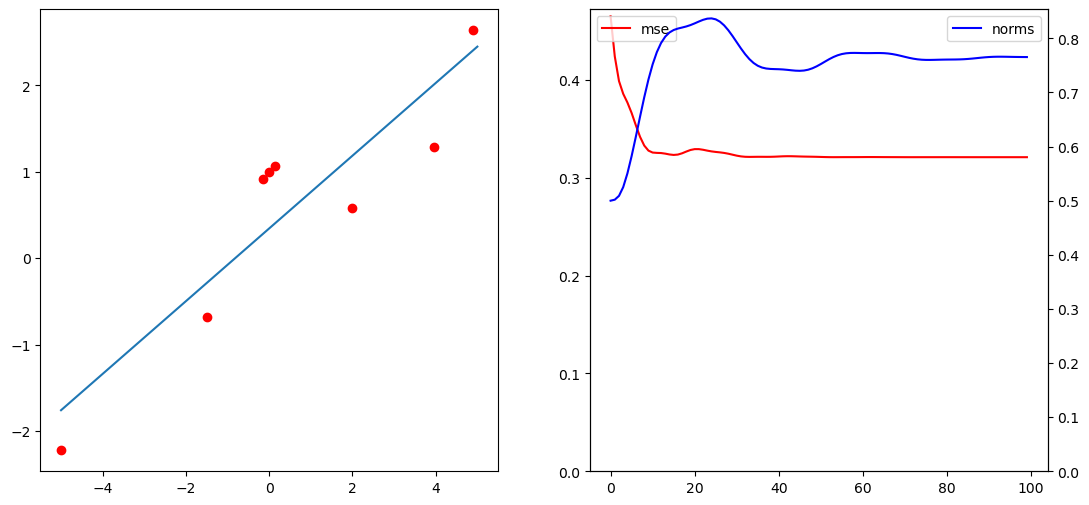

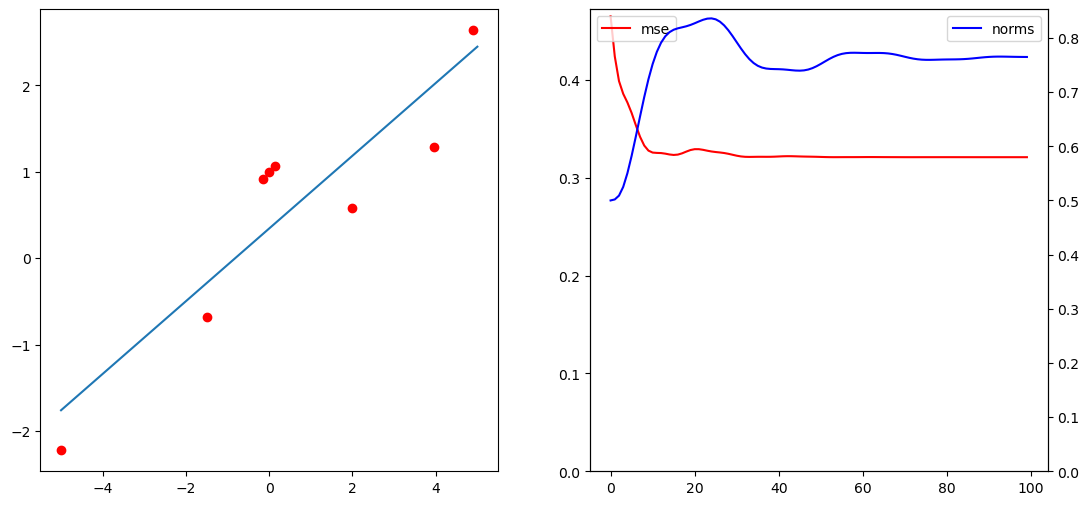

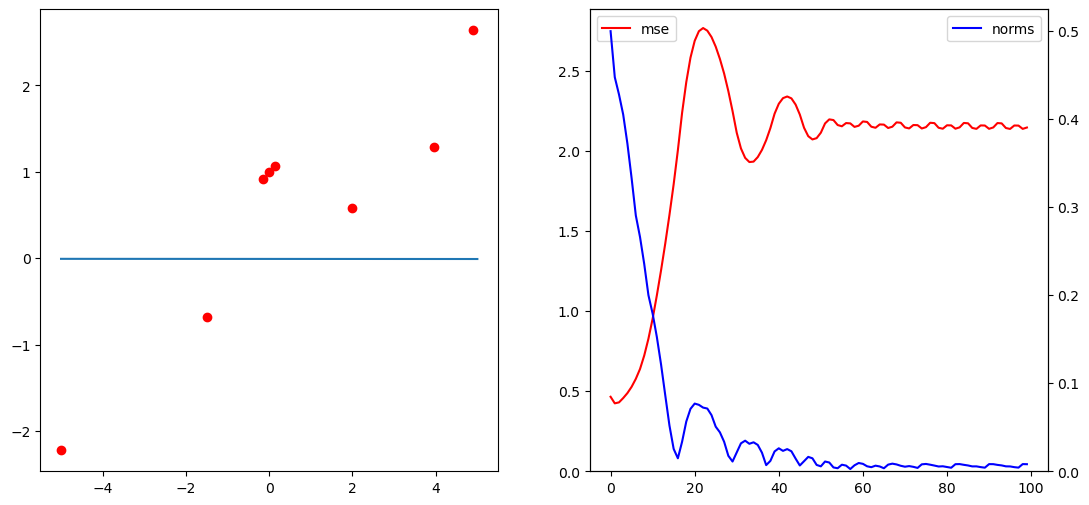

In [7]:
def plot_training_result(model, losses, norms):
    fig, axs = plt.subplots(ncols=2, figsize=(13, 6))
    axs[0].plot(xs.detach(), model(xs.float().unsqueeze(-1)).detach())
    axs[0].scatter(data, ts, c='r')

    axs[1].plot(losses, 'r-', label='mse')
    axs[1].legend(loc="upper left")
    axs[1].set_ylim(bottom=0)
    ax_2 = axs[1].twinx()
    ax_2.plot(norms, 'b-', label='norms')
    ax_2.legend(loc="upper right")
    ax_2.set_ylim(bottom=0)


xs = torch.linspace(-5, 5, steps=100)
data = torch.tensor([-4.99, 3.95, -1.5, -0.15, 0, 0.15, 2, 4.9]).unsqueeze(-1)
ts = func(data).squeeze(-1).detach()

def try_beta(l2_beta):
    regr_1 = LinearRegression(1)
    opt = torch.optim.Adam(regr_1.parameters(), 3e-2)
    losses, norms = train_regression_model(regr_1, MSE_with_regression(l2_beta), opt, data, ts)
    plot_training_result(regr_1, losses, norms)
try_beta(1e-10)
try_beta(1e-3)
try_beta(1e+5)

Zde doimplementujte metodu forward pro `PolynomialRegression`.
Je potřeba vytvořit rozšířené příznaky a slepit je do jednoho tensoru o tvaru `[N, F]`, který předložíte `self.lin_reg`.
Nezapomeňte pak výstup opět omezit na `[N]`.

Zbytek buňky Vám model natrénuje v několika různých variantách řádu polynomu a síly regularizace.

In [ ]:
class PolynomialRegression1D(torch.nn.Module):
    def __init__(self, order):
        super().__init__()
        self.order = order
        self.lin_reg = LinearRegression(order)
        
    def forward(self, x):
        # create polynomial features
        y_p = []
        for p in range(self.order):
            y_p.append(x**p)
        y = torch.cat(y_p, dim=1)
        
        return self.lin_reg(y)
        
    def l2_norm(self):
        return self.lin_reg.l2_norm()            

def run_polynomial_regr(order, l2_beta):
    model = PolynomialRegression1D(order)

    losses, norms = train_regression_model(
        model,
        MSE_with_regression(l2_beta),
        torch.optim.Adam(model.parameters(), 1e-2),
        data,
        ts,
        nb_steps= 50 + int(100*(order-2)**2.5)
    )
    plot_training_result(model, losses, norms)

run_polynomial_regr(3, 1e-3)
run_polynomial_regr(3, 1e+2)
run_polynomial_regr(7, 1e-1)
run_polynomial_regr(7, 1e+3)


# Regrese meteorologických dat
V této části budete usilovat o doplnění tlaku vzduchu z dalších meteorologických měření.
Nejprve pomocí lineární regrese, následně pomocí jednoduché neuronové sítě.
Každopádně více pomocí vestavěných věcí z PyTorche.

In [ ]:
turany = np.loadtxt('data-chmu/turany.txt', dtype=np.float32)
mosnov = np.loadtxt('data-chmu/mosnov.txt', dtype=np.float32)
kosetice = np.loadtxt('data-chmu/kosetice.txt', dtype=np.float32)
ruzyne = np.loadtxt('data-chmu/ruzyne.txt', dtype=np.float32)
pribyslav = np.loadtxt('data-chmu/pribyslav.txt', dtype=np.float32)

features = ['teplota průměrná', 'teplota maximální', 'teplota minimální', 'rychlost větru ', 'tlak vzduchu', 'vlhkost vzduchu', 'úhrn srážek', 'celková výška sněhu', 'sluneční svit']

V prvním kroce doplňte definici `MeteoDataset`u o `__getitem__()` a `__len__()`, tak jak se to očekává u objektů třídy `torch.utils.data.Dataset`.
Navíc přidejte vlastnost (`@property`) `in_dim`, která říká, kolik příznaků má každé jedno dato v datasetu.

In [ ]:
class MeteoDataset(torch.utils.data.Dataset):
    def __init__(self, data, target_feature):
        self.ts = data[target_feature]
        self.xs = data[[i for i in range(data.shape[0]) if i != target_feature]].T        
        
    def __getitem__(self, idx):
        return self.xs[idx], self.ts[idx]
    
    def __len__(self):
        return self.xs.shape[0]

    @property
    def in_dim(self):
        return self.xs.shape[1]
    
target_feature = 'tlak vzduchu'
train_dataset = MeteoDataset(np.concatenate([mosnov, kosetice, pribyslav], axis=1), features.index(target_feature))
valid_dataset = MeteoDataset(ruzyne, features.index(target_feature))
test_dataset = MeteoDataset(ruzyne, features.index(target_feature))
print(valid_dataset.xs.shape, valid_dataset.ts.shape)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False, drop_last=False)
print(len(valid_loader))

Zde je definována funkce pro evaluaci modelu.
Budete ji používat, ale implementovat v ní nic nemusíte.

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    total_squared_error = 0.0
    nb_datos = 0
    with torch.no_grad():
        for X, t in data_loader:
            y = model(X)
            total_squared_error += torch.nn.functional.mse_loss(y, t, reduction='sum')
            nb_datos += len(t)
        
    return total_squared_error / nb_datos

evaluate(LinearRegression(train_dataset.in_dim), valid_loader)

Nad trénovacím dataset vytvořte `DataLoader`, který bude vytvářet minibatche o velikosti 32 příkladů.
Poté z něj vytvořte nekonečný proud dat.
Můžete k tomu naimplementovat vlastní cyklící iterátor nebo použít vhodnou funkci z `itertools`.

Dále naimplementujte trénovací smyčku ve funkci `train()`, která přijímá:
* `model` -- referenci na model, jenž má být natrénován
* `train_stream` -- iterátor přes trénovací batche
* `optimizer` -- instanci optimalizátoru,  který bude využit pro trénování
* `nb_updates` -- počet trénovacích kroků, jež mají být provedeny
* `eval_period` -- po kolika krocích se má vyhodnocovat model na validačních datech
* `valid_loader` -- iterable s validačními daty

Funkce nechť používá `torch.nn.functional.mse_loss()` jako loss.
Vracejte průběh validační loss spolu s pořadovými čísly kroků, kdy došlo k měření, tedy jako seznam dvojic `[(i_1, loss_1), ...]`.
`model` trénujte přímo.

Zbytek buňky vyzkouší trénování pro několik různých learning rate.
Vzhledem k jednoduchosti úlohy jsou to learning rate gigantické oproti prakticky používaným.

In [ ]:
from itertools import cycle

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

train_stream = cycle(train_loader)

def train(model, train_stream, optimizer, nb_updates, eval_period, valid_loader):
    valid_progress = []
    
    model.train()
    for i in range(nb_updates):
        train_x, train_t = next(train_stream)
        # calculate the prediction
        pred = model(train_x)
        #calculate the loss
        loss = torch.nn.functional.mse_loss(pred, train_t)
        #compute gradients
        loss.backward()
        #update weights
        optimizer.step()
        #reset gradients to zero
        optimizer.zero_grad()
    
        #append loss
        if i % eval_period == 0:
            valid_progress.append((i, evaluate(model, valid_loader).item()))

    return valid_progress

def lr_progress(lr):
    linear_predictor = LinearRegression(train_dataset.in_dim)
    optimizer = torch.optim.Adam(linear_predictor.parameters(), lr)
    progress = train(linear_predictor, train_stream, optimizer, 250, 10, valid_loader)
    print(lr, evaluate(linear_predictor, valid_loader))
    return progress

plt.figure(figsize=(10, 8))
for lr in [3e+1, 1e+1, 1e+0, 3e-1]:
    progress = lr_progress(lr)
    plt.plot([item[0] for item in progress], [item[1] for item in progress], label=f"{lr:.1e}")
plt.legend()
plt.ylim(0, 30000)
plt.show()

Konečně naimplementujte jednoduchou neuronovou síť, která bude schopná regrese.
Při konstrukci nechť přijímá:
* rozměr vstupu
* počet skrytých vstev
* šířku každé skryté vrstvy
* instanci nelinearity, která má být aplikována v každé skryté vrstvé

Při dopředném průchodu nechť se uplatní všechny vrstvy, nezapomeňte opět redukovat výstup na [N].
Nejspíš se Vám bude hodit `torch.nn.Sequential`.

Zbytek buňky vyzkouší několik různých konfigurací.
Pravděpodobně uvidíte ilustraci faktu, že v rozporu s častou reportovací praxí není počet parametrů nutně tím nejzásadnějším číslem pro odhad síly modelu, tím může být prostě šířka.

In [ ]:
class LocalMeteoModel(torch.nn.Module):
    def __init__(self, input_dim, nb_layers, layer_width, nonlinearity):
        super().__init__()
        self.input_dim = input_dim
        assert nb_layers >= 1
        
        self.trace = []
        
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(self.input_dim, layer_width))
        self.layers.append(nonlinearity)
        
        for i in range(nb_layers):
            self.layers.append(torch.nn.Linear(layer_width, layer_width))
            self.layers.append(nonlinearity)
            
        self.layers.append(torch.nn.Linear(layer_width, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x).squeeze()
            self.trace.append(x)
        return x
    

def depth_progress(depth, width):
    nn_predictor = LocalMeteoModel(train_dataset.in_dim, depth, width, torch.nn.Tanh())
    optimizer = torch.optim.SGD(nn_predictor.parameters(), 3e-5)
    progress = train(nn_predictor, train_stream, optimizer, 1500, 100, valid_loader)
    print(f"Depth {depth}, width {width}: {evaluate(nn_predictor, valid_loader):.2f}")
    return progress

plt.figure(figsize=(10, 8))
for depth, width in [(1, 16), (4, 16), (1, 64), (4, 64)]:
    progress = depth_progress(depth, width)
    plt.plot([item[0] for item in progress], [item[1] for item in progress], label=f"{depth}x{width}")
plt.legend()
plt.show()

Gratulujeme ke zvládnutí projektu! Při odevzdání nezapomeňte soubory pojmenovat podle vedoucího týmu.